<a href="https://colab.research.google.com/github/ML-HW-SYS/a2/blob/main/3_training_and_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3. Training and Testing**
Please start early! Section 3.6 Training may take one to two hours to run.

## 3.0 Setup GDrive and Git

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Make sure your token is stored in a txt file at the location below.
# This way there is no risk that you will push it to your repo
# Never share your token with anyone, it is basically your github password!
with open('/content/gdrive/MyDrive/token.txt') as f:
    token = f.readline().strip()
# Use another file to store your github username
with open('/content/gdrive/MyDrive/git_username.txt') as f:
    handle = f.readline().strip()

In [3]:
# Clone your github repo
YOUR_TOKEN = token
YOUR_HANDLE = handle
BRANCH = "main"

# %mkdir /content/gdrive/MyDrive/ece5545
# %cd /content/gdrive/MyDrive/ece5545
# !git clone https://{YOUR_TOKEN}@github.com/ML-HW-SYS/a2-{YOUR_TOKEN}.git
# %cd /content/gdrive/MyDrive/ece5545/a2-{YOUR_TOKEN}
# !git checkout {BRANCH}
# !git pull
%cd /content/gdrive/MyDrive/mlhs

PROJECT_ROOT = f"/content/gdrive/MyDrive/mlhs/mlhs-a2"

/content/gdrive/MyDrive/mlhs


In [4]:
# This extension reloads all imports before running each cell
%load_ext autoreload
%autoreload 2

### GPU

Ensure you are running the GPU runtime type:
1.   Click "Runtime" on top banner
2.   Select "Change runtime type"
3.   Under "Hardware accelarator" select "GPU" and save



### Import code dependencies

In [5]:
import os
import sys

# Adding assignment 2 to the system path
# -- make sure this matches your git directory
sys.path.insert(0, PROJECT_ROOT)

# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import copy

# Import constants to use constants defined for training
from src.constants import *
# Import data_proc to use data processing functions
import src.data_proc as data_proc

random_seed = 0
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

Model folders are created, 
PyTorch models will be saved in /content/gdrive/MyDrive/mlhs/models/torch_models, 
ONNX models will be saved in /content/gdrive/MyDrive/mlhs/models/onnx_models, 
TensorFlow Saved Models will be saved in /content/gdrive/MyDrive/mlhs/models/tf_models, 
TensorFlow Lite models will be saved in /content/gdrive/MyDrive/mlhs/models/tflite_models, 
TensorFlow Lite Micro models will be saved in /content/gdrive/MyDrive/mlhs/models/micro_models.


## 3.1 Download and Preprocess Data

### Create audio processor
This step is similar to what was done in part 2, so the files should already be downloaded in your Google Drive.

In [6]:
# Create audio_processor
audio_processor = data_proc.AudioProcessor()

>> Downloading speech_commands_v0.02.tar.gz 100.0%


### Select device: cuda or cpu

In [7]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} to run the training scrpit.')

Using cuda to run the training scrpit.


## 3.2 Data Loader

In [8]:
# Define train, test, and validation set
train_set = audio_processor.data_index['training']
test_set = audio_processor.data_index['testing']
valid_set = audio_processor.data_index['validation']

# Define data loaders
from src.loaders import make_data_loaders
data_loaders = make_data_loaders(audio_processor, device)
train_loader = data_loaders['training']
test_loader = data_loaders['testing']
valid_loader = data_loaders['validation']

Train size: 10556 Val size: 1333 Test size: 1368


## 3.3 Define the Model

In [9]:
from src.networks import TinyConv
# Create a full precision (float32) TinyConv model
model_fp32 = TinyConv(
    model_settings=audio_processor.model_settings,
    n_input=1,
    n_output=audio_processor.num_labels
)
model_fp32

TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

## 3.4 Training

In [10]:
from src.train_val_test_utils import train, test

### Adjust parameters
*   You can change *n_epoch* to use a different number training steps/epochs

In [11]:
num_batches = len(train_loader)
n_epoch = 50
print(f'# batches: {num_batches} \n# epochs: {n_epoch} \n# total training steps: {num_batches * n_epoch}')

# batches: 106 
# epochs: 50 
# total training steps: 5300


### Create optimizer for training
 Explore more at:
[TORCH. OPTIM](https://pytorch.org/docs/stable/optim.html?highlight=torch%20optim%20lr_scheduler)

In [12]:
from src.train_val_test_utils import create_optimizer

# Create optimizer
optimizer_fp32 = create_optimizer(model=model_fp32, learning_rate=0.001)
print(optimizer_fp32.state_dict())

{'state': {}, 'param_groups': [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0001, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'params': [0, 1, 2, 3]}]}


### Train the model
TensorBoard will allow you to visualize your results. The second code block, the training, will take a while to run.

In [15]:
from torch.utils.tensorboard import SummaryWriter

pbar_update = 1 / (len(train_loader) + len(test_loader) + len(valid_loader))

def run_training(model, data_loaders, n_epoch, optimizer,
                 save_interval=1, resume=True, checkpoint_path=None):
    writer = SummaryWriter()  # Initialize the TensorBoard writer

    train_loader = data_loaders['training']
    valid_loader = data_loaders['validation']

    test_loader = data_loaders['testing']
    with tqdm(total=n_epoch) as pbar:

        completed_epoch = 1
        if resume:
            try:
                #continue training with previous model if one exists
                checkpoint = torch.load(checkpoint_path)
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                completed_epoch = checkpoint["epoch"] + 1
                model.eval()
                pbar.update(completed_epoch)
            except:
                pass

        last_valacc = 0
        for epoch in range(completed_epoch, n_epoch + 1):
            # Perform a single epoch of training
            train(model, data_loaders, optimizer, epoch, device)
            train_accuracy = test(train_loader, model, device, epoch=epoch,
                          loader_type='Train', verbose=True)

            writer.add_scalar('Accuracy/train', train_accuracy, epoch)

            train_iters = len(data_loaders['training'])

            valacc = test(valid_loader, model, device, epoch=epoch,
                          loader_type='Valid', verbose=True)

            writer.add_scalar('Accuracy/valid', valacc, epoch)
            #checkpoint the model every epoch
            if epoch % save_interval == 0 and valacc > last_valacc:
                last_valacc = valacc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict()
                }, checkpoint_path)

            # Update epoch pbar
            pbar.update(1)

        testacc = test(test_loader, model, device,
                     epoch=None, loader_type='Test')
        print(f'Test Acc = {round(testacc,2)}%')
    writer.close()


# This is where your checkpoint file will be saved
checkpoint_path = os.path.join(TORCH_DIR, "fp32_checkpoint.pt")

model_fp32.to(device)
run_training(
    model=model_fp32, data_loaders=data_loaders,
    n_epoch=n_epoch, optimizer=optimizer_fp32,
    resume=False, checkpoint_path=checkpoint_path
)

  0%|          | 0/50 [00:00<?, ?it/s]

Val Acc Epoch 1 = 83.5%, Train loss = 1.097

Train epoch: 1	Accuracy: 8387/10556 (79.45%)


Valid epoch: 1	Accuracy: 1105/1333 (82.90%)

Val Acc Epoch 2 = 86.35%, Train loss = 0.566

Train epoch: 2	Accuracy: 8920/10556 (84.50%)


Valid epoch: 2	Accuracy: 1153/1333 (86.50%)

Val Acc Epoch 3 = 86.27%, Train loss = 0.487

Train epoch: 3	Accuracy: 9036/10556 (85.60%)


Valid epoch: 3	Accuracy: 1158/1333 (86.87%)

Val Acc Epoch 4 = 85.82%, Train loss = 0.463

Train epoch: 4	Accuracy: 9091/10556 (86.12%)


Valid epoch: 4	Accuracy: 1151/1333 (86.35%)

Val Acc Epoch 5 = 88.07%, Train loss = 0.445

Train epoch: 5	Accuracy: 9157/10556 (86.75%)


Valid epoch: 5	Accuracy: 1166/1333 (87.47%)

Val Acc Epoch 6 = 87.77%, Train loss = 0.433

Train epoch: 6	Accuracy: 9175/10556 (86.92%)


Valid epoch: 6	Accuracy: 1169/1333 (87.70%)

Val Acc Epoch 7 = 88.67%, Train loss = 0.428

Train epoch: 7	Accuracy: 9248/10556 (87.61%)


Valid epoch: 7	Accuracy: 1186/1333 (88.97%)

Val Acc Epoch 8 = 86.8%, Train loss

## 3.5 Testing

### Calculating accuracy


Train size: 10556 Val size: 1333 Test size: 1368


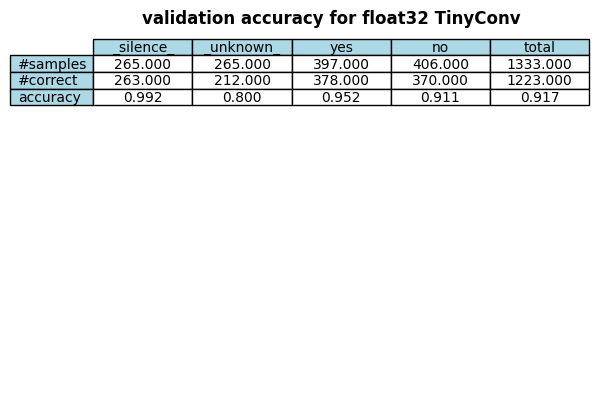

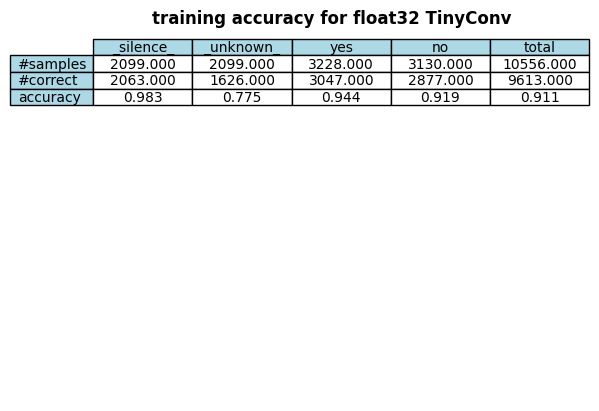

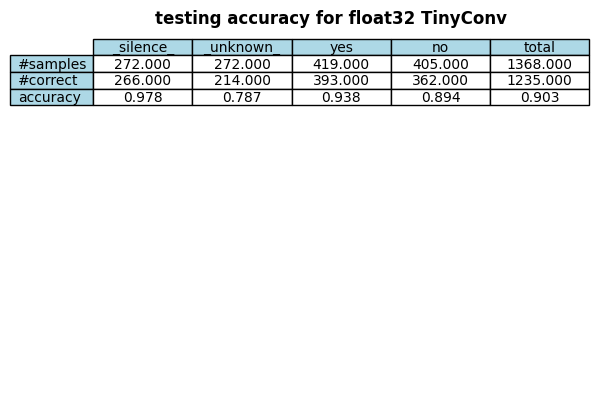

In [16]:
from src.train_val_test_utils import plot_acc

test_time_data_loaders = make_data_loaders(
    audio_processor, device,
    test_batch_size=1, valid_batch_size=1,
    num_workers=0
)

plot_acc(
    test_time_data_loaders['validation'], model_fp32, audio_processor, device,
    "validation", 'float32 TinyConv', "float")
plot_acc(
    test_time_data_loaders['training'], model_fp32, audio_processor, device,
    "training", 'float32 TinyConv', "float")
acc = plot_acc(
    test_time_data_loaders['testing'], model_fp32, audio_processor, device,
    'testing', 'float32 TinyConv', "float")

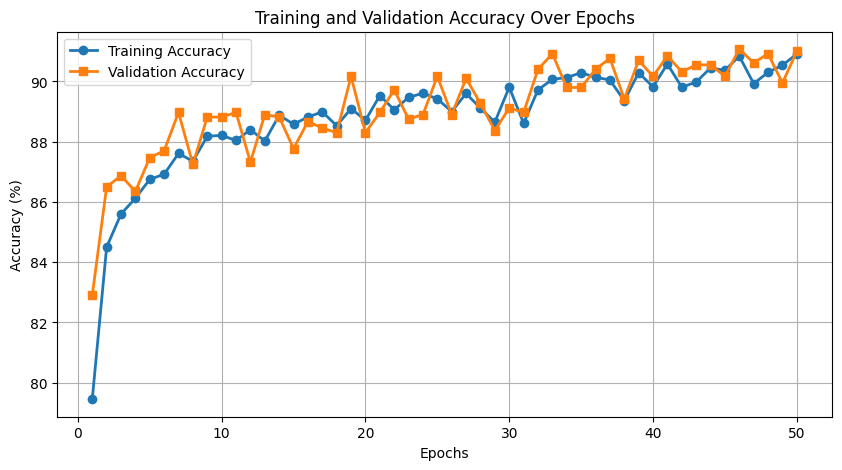

In [27]:
import matplotlib.pyplot as plt

# Define the epochs and accuracies
epochs = range(1, 51)
train_accuracies = [
    79.45, 84.50, 85.60, 86.12, 86.75, 86.92, 87.61, 87.35,
    88.18, 88.21, 88.04, 88.40, 88.02, 88.88, 88.58, 88.82,
    88.99, 88.53, 89.10, 88.71, 89.53, 89.06, 89.47, 89.61,
    89.42, 89.00, 89.60, 89.11, 88.65, 89.81, 88.61, 89.72,
    90.07, 90.13, 90.29, 90.14, 90.05, 89.36, 90.29, 89.82,
    90.58, 89.81, 89.98, 90.45, 90.37, 90.84, 89.93, 90.30,
    90.54, 90.91
]

val_accuracies = [
    82.90, 86.50, 86.87, 86.35, 87.47, 87.70, 88.97, 87.25,
    88.82, 88.82, 88.97, 87.32, 88.90, 88.82, 87.77, 88.67,
    88.45, 88.30, 90.17, 88.30, 88.97, 89.72, 88.75, 88.90,
    90.17, 88.90, 90.10, 89.27, 88.37, 89.12, 88.97, 90.40,
    90.92, 89.80, 89.80, 90.40, 90.77, 89.42, 90.70, 90.17,
    90.85, 90.32, 90.55, 90.55, 90.17, 91.07, 90.62, 90.92,
    89.95, 91.00
]


# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, 'o-', linewidth=2, label='Training Accuracy')
plt.plot(epochs, val_accuracies, 's-', linewidth=2, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()
plt.show()


## 3.6 Save the Trained Model

In [17]:
def choose_name(model_name):
    name = f"{model_name}_" + "{index}"
    i = 0
    while os.path.isfile(name.format(index=i)):
        i += 1
    name = name.format(index = i)
    print(f"The model's will be stored as: \n {name}")
    return name

def save_model(model, path):
    torch.save(model.state_dict(), path)

In [18]:
# Choose a path
# You can also define your own path
model_name = f"tinyconv_float32_init_seed{torch.initial_seed()}_{acc * 100:.2f}%"
file_name = choose_name(model_name)
torch_path = os.path.join(TORCH_DIR, f'{file_name}.pt')
torch_path

The model's will be stored as: 
 tinyconv_float32_init_seed0_90.28%_0


'/content/gdrive/MyDrive/mlhs/models/torch_models/tinyconv_float32_init_seed0_90.28%_0.pt'

In [19]:
# Save the trained pytorch model to torch_path
save_model(model_fp32, torch_path)
'Saved!'

'Saved!'

In [20]:
'You can now find your model in %s under the folder icon to the left.' % torch_path

'You can now find your model in /content/gdrive/MyDrive/mlhs/models/torch_models/tinyconv_float32_init_seed0_90.28%_0.pt under the folder icon to the left.'